# PCA 실습

### 차원축소(dimensionality reduction)와 변수추출(feature extraction) 기법
널리 쓰이고 있는 주성분분석(Principal Component Analysis)

In [1]:
import numpy as np  # 수치 연산
import pandas as pd  # 데이터프레임
import seaborn as sns  # 시각화
import matplotlib.pyplot as plt  # 시각화(저수준)
from sklearn.datasets import load_iris  # 아이리스 데이터
from sklearn.preprocessing import StandardScaler  # 표준화
from sklearn.decomposition import PCA  # 주성분분석


In [2]:

# 1) 데이터 로드
iris = load_iris()  # 특징 행렬(iris.data), 타깃 벡터(iris.target), 특징 이름(iris.feature_names)


In [3]:

# 2) 판다스 데이터프레임으로 정리
iris_pd = pd.DataFrame(iris.data, columns=iris.feature_names)  # 특징 값과 컬럼명 설정
iris_pd["species"] = iris.target  # 타깃(0,1,2)을 열로 추가



In [4]:

# 3) 상위 몇 행 확인
print(iris_pd.head(3))  # 데이터 구조와 값 스팟체크


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   

   species  
0        0  
1        0  
2        0  


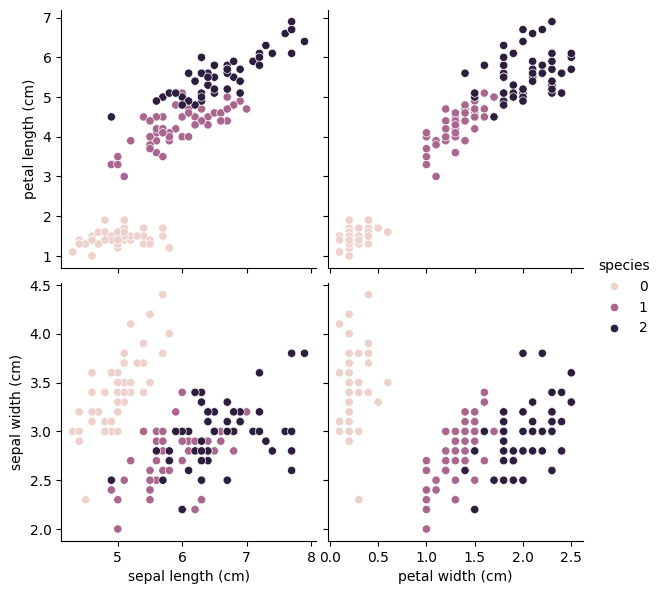

In [5]:

# 4) 변수 간 관계 시각화(선택한 축만)
sns.pairplot(
    iris_pd,
    hue="species",  # 종에 따라 색 구분
    height=3,  # 서브플롯 크기
    x_vars=["sepal length (cm)", "petal width (cm)"],  # x축 변수들
    y_vars=["petal length (cm)", "sepal width (cm)"],  # y축 변수들
)
plt.show()


In [6]:

# 5) 스케일 표준화(평균 0, 분산 1) — PCA 전처리로 권장
scaler = StandardScaler()  # 표준화 객체 생성
iris_ss = scaler.fit_transform(iris.data)  # 데이터 적합/변환
print(iris_ss[:3])  # 변환된 값 일부 확인


[[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]]


In [7]:

# 6) PCA 적용 함수 정의
def get_pca_data(ss_data, n_components=2):
    """
    표준화된 데이터(ss_data)에 PCA를 학습시키고,
    변환된 주성분 좌표와 PCA 객체를 반환한다.
    """
    pca = PCA(n_components=n_components)  # n개 주성분 보존
    pca.fit(ss_data)  # 분산 최대화 방향(주성분) 학습
    return pca.transform(ss_data), pca  # 주성분 좌표로 투영, 학습된 pca 반환


In [8]:

# 7) 아이리스 데이터에 PCA(2차원) 적용
iris_pca, pca = get_pca_data(iris_ss, n_components=2)


In [9]:

# 8) 변환 결과 차원 확인 (150개 샘플 × 2개 주성분)
print(iris_pca.shape)


(150, 2)


In [10]:

# 9) PCA 속성 확인
print("pca.mean_:", pca.mean_)  # 학습 시 사용한 각 특징의 평균 (표준화 후라 거의 0)
print("pca.components_:\n", pca.components_)  # 각 주성분 벡터(원변수에 대한 가중치)
print("explained_variance_ratio_:", pca.explained_variance_ratio_)  # 각 주성분이 설명하는 분산 비율


pca.mean_: [-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]
pca.components_:
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]
explained_variance_ratio_: [0.72962445 0.22850762]


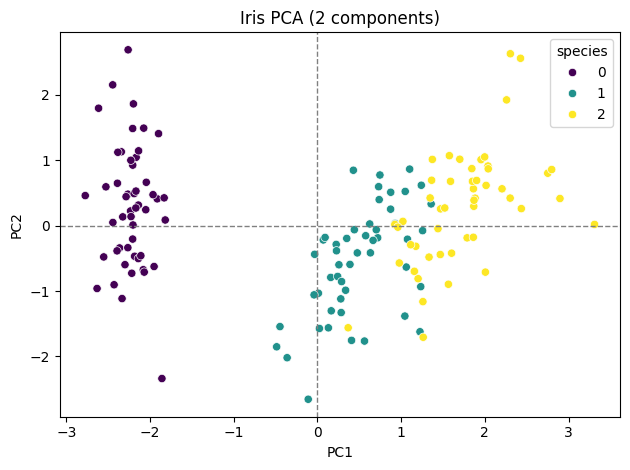

In [11]:

# 10) 주성분 2차원 산점도 시각화
pca_df = pd.DataFrame(iris_pca, columns=["PC1", "PC2"])  # 주성분 좌표 데이터프레임
pca_df["species"] = iris.target  # 종 라벨 병합
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="species", palette="viridis")  # 2D 시각화
plt.axhline(0, color="gray", lw=1, ls="--")  # 기준선(가독성)
plt.axvline(0, color="gray", lw=1, ls="--")
plt.title("Iris PCA (2 components)")
plt.tight_layout()
plt.show()

In [13]:
# 11) PCA 분산 비율 출력 및 RandomForest 교차검증 결과 비교

# 11.1) PCA 분산비 출력
def print_variance_ratio(pca):
    print("variance_ratio:", pca.explained_variance_ratio_)
    print("sum of variance_ratio", np.sum(pca.explained_variance_ratio_))

print_variance_ratio(pca)



variance_ratio: [0.72962445 0.22850762]
sum of variance_ratio 0.9581320720000166


In [16]:

# 11.2) RandomForest 교차검증 함수 정의/실행
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


def rf_scores(X, y, cv=5):
    rf = RandomForestClassifier(random_state=13, n_estimators=100)
    scores_rf = cross_val_score(rf, X, y, scoring="accuracy", cv=cv)
    print("Score :", np.mean(scores_rf))

# 원본(표준화된) 입력에 대한 성능
rf_scores(iris_ss, iris.target)


Score : 0.96


In [17]:

# PCA(2개 성분) 투영 결과에 대한 성능
pca_X = pd.DataFrame(iris_pca, columns=["pca_component_1", "pca_component_2"])
rf_scores(pca_X, iris.target)

Score : 0.9066666666666666
